In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Parse Transcriptions

In [2]:
from collections import defaultdict, Counter
import codecs

def parse_pages(path='text16e6.evt'):
  '''
  Return a mapping from single character representation of transcriptor to
  array of line strings.
  @kwarg str path: the path to the voynich full text
  @returns
    [str] page_order: a list of the page keys in order
    dict d: # d[annotator][page] = ['line_one', 'line_two']
  '''
  page_order = []
  d = defaultdict(lambda: defaultdict(list))
  with codecs.open('text16e6.evt', 'r', 'latin1') as f:
    f = f.read()
    for line_idx, line in enumerate(f.split('\n')):
      if not line.strip(): continue
      if line[0] != '<': continue # skip paratextual lines
      meta = line.split('<')[1].split('>')[0]
      if '.' not in meta: # indicates the start of a new page (e.g. <f1r>)
        page_order.append(meta)
        continue 
      page, sheet, line_num_and_annotator = meta.split('.')
      line_num, annotator = line_num_and_annotator.split(';')
      if '>' not in line: continue
      if not page: continue # skip the page id 0
      line_text = line.split('>')[1].strip()
      d[annotator][page].append(line_text)
  return page_order, d
      
page_order, line_map = parse_pages()

# Select Data

In [3]:
# each key in line_map is a transcriber
line_map.keys()

# show how many pages each transcriber transcribed
for k in line_map: print(k, len(line_map[k]))

Z 1
U 123
X 2
H 225
T 12
F 202
C 145
J 4
K 13
I 1
Q 3
L 10
N 1
G 36
R 1
P 1
D 13
V 68


In [4]:
# select the annotator to use (Takahashi)
annotator = 'H'

# set page array
pages = line_map[annotator]

# Download Images

In [5]:
from os.path import join
import requests
import os

def download_from_url(url, out_path):
  '''Download a file at location `url` and write to `out_path`'''
  if not os.path.exists(out_path):
    r = requests.get(url, allow_redirects=True)
    open(out_path, 'wb').write(r.content)

def download_voynichese_coords(page_id):
  '''Download the page coords for `page_id` from voynichese.com'''
  url = 'http://www.voynichese.com/2/data/folio/script/' + page_id + '.js'
  download_from_url(url, join('voynichese', 'coords', page_id + '.js'))

def download_voynichese_page(page_id):
  '''Download a page image with page id `page_id` from voynichese.com'''
  url = 'http://www.voynichese.com/2/data/folio/image/glance/color/large/' + page_id + '.jpg'
  download_from_url(url, join('voynichese', 'images', page_id + '.jpg'))

def download_voynichese_data(page_ids):
  '''Download page images and word coords from voynichese.com'''
  for i in ['coords', 'voynichese-images']:
    if not os.path.exists(join('voynichese', i)):
      os.makedirs(join('voynichese', i))
  for page_id in page_ids:
    download_voynichese_coords(page_id)
    download_voynichese_page(page_id)

download_voynichese_data(pages.keys())

# Helpers

In [6]:
from collections import defaultdict
from skimage.transform import resize
from skimage.util import montage
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from math import ceil, floor
from scipy import ndimage
import numpy as np
import os, re, glob, json

##
# Show a single page image
##

def get_page_image(page_id):
  '''Return a numpy array of a voynichese page image for `page_id`'''
  return ndimage.imread(os.path.join('voynichese', 'images', page_id + '.jpg'))

def show_page(page_id, figsize=(6, 14)):
  '''Show the page image for a given page identifier (e.g.) f1r'''
  plt.figure(figsize=figsize)
  plt.imshow(get_page_image(page_id))

##
# Show frequency of string over course of text
##
  
def plot_string_freq(s, figsize=(14, 1.4), clean=True):
  '''Given a string `s` plot its distribution over pages'''
  y = [get_page_string(i, clean=clean).count(s) for i in page_order]
  x = list(range(len(page_order)))
  plt.figure(figsize=figsize)
  plt.bar(x, y)
  plt.title(s)

def get_page_string(page_id, clean=True):
  '''Return a string of the content from page `page_id` (e.g. f1r)'''
  page_string = ' '.join(pages.get(page_id, []))
  if clean: return clean_string(page_string)
  return page_string

def flatten(arr):
  '''Flatten a 2d array to 1d'''
  return [j for i in arr for j in i]

def get_words(clean=True, unique=False):
  '''Find the set of all words in the corpus'''
  words = flatten([get_page_string(i, clean=clean).split('.') for i in page_order])
  words = [i for i in words if i] # remove empty words
  if unique: return set(words)
  return words

def clean_string(s):
  '''Clean a voynich word string'''
  s = s.replace('!', '').replace('%', '') # replace needless characters
  s = s.replace('-', '.') # replace line breaks with word break (all line breaks assumed to be word breaks)
  s = s.replace('=', '.') # replace end line comments with word break
  s = s.replace(' ', '.') # replace whitespace with word break
  s = re.sub(r'\{[^\{\}]+?\}', '', s) # drop content between {} github.com/viking-sudo-rm/voynich2vec/vms_tokenize.py
  return s

##
# Show all occurrences of a word
##

def get_word_map():
  '''
  Find all occurrences of a word and return a map from:
    d[word][page_id] = [numpy_array_of_word_image, numpy_array_of_word_image]
  '''
  word_map = defaultdict(lambda: defaultdict(list))
  # Find all occurrences of a word
  for page_id in pages:
    page_image = get_page_image(page_id)
    with open(join('voynichese', 'coords', page_id + '.js')) as f:
      words, coords = json.load(f)
      word_list = []
      for word, _, _, _ in words:
        word_list.append(word)
      for word_idx, x, y, w, h in coords:
        cropped = page_image[y:y+h,x:x+w]
        if any([i == 0 for i in cropped.shape]): continue
        word_map[word_list[word_idx]][page_id].append(cropped)
  return word_map

def resize_img(arr, size=(100, 20), anti_aliasing=False):
  return resize(arr, size, anti_aliasing=anti_aliasing)

def show_word_occurrences(word, figsize=(12, 8), grid_shape=None, grayscale=False, skip_verticals=True):
  '''
  Plot a montage of all instances of `word` in the voynich ms
  @arg tuple figsize: the plot size
  @arg tuple grid_shape: the number of rows, cols to include in the montage
  @arg bool grayscale: whether to plot words in grayscale
  @arg bool skip_verticals: skip words with vertical orientation
  '''
  imgs = flatten( [word_map.get(word, [])[page_id] for page_id in word_map.get(word, [])] )
  if skip_verticals: imgs = [i for i in imgs if i.shape[0] < i.shape[1]]
  if not imgs: raise Exception(' ! word has no images')
  size = imgs[0].shape
  resized = np.array([resize_img(i, size=size) for i in imgs])
  if figsize: plt.figure(figsize=figsize)
  composite = montage(resized, multichannel=True, grid_shape=grid_shape)
  if grayscale:
    plt.imshow(rgb2gray(composite), cmap=plt.cm.binary)
  else:
    plt.imshow(composite)

##
# Label each word occurrence
##

def label_word_occurrences(word):
  '''Plot each occurrence of a word with a page and index label'''
  for page_id in word_map.get(word, []):
    for idx, i in enumerate(word_map['shedy'][page_id]):
      plt.figure(figsize=(4,1.4))
      plt.title(page_id + ' ' + str(idx))
      plt.imshow(word_map['shedy'][page_id][idx])
      plt.show()

# Data Exploration

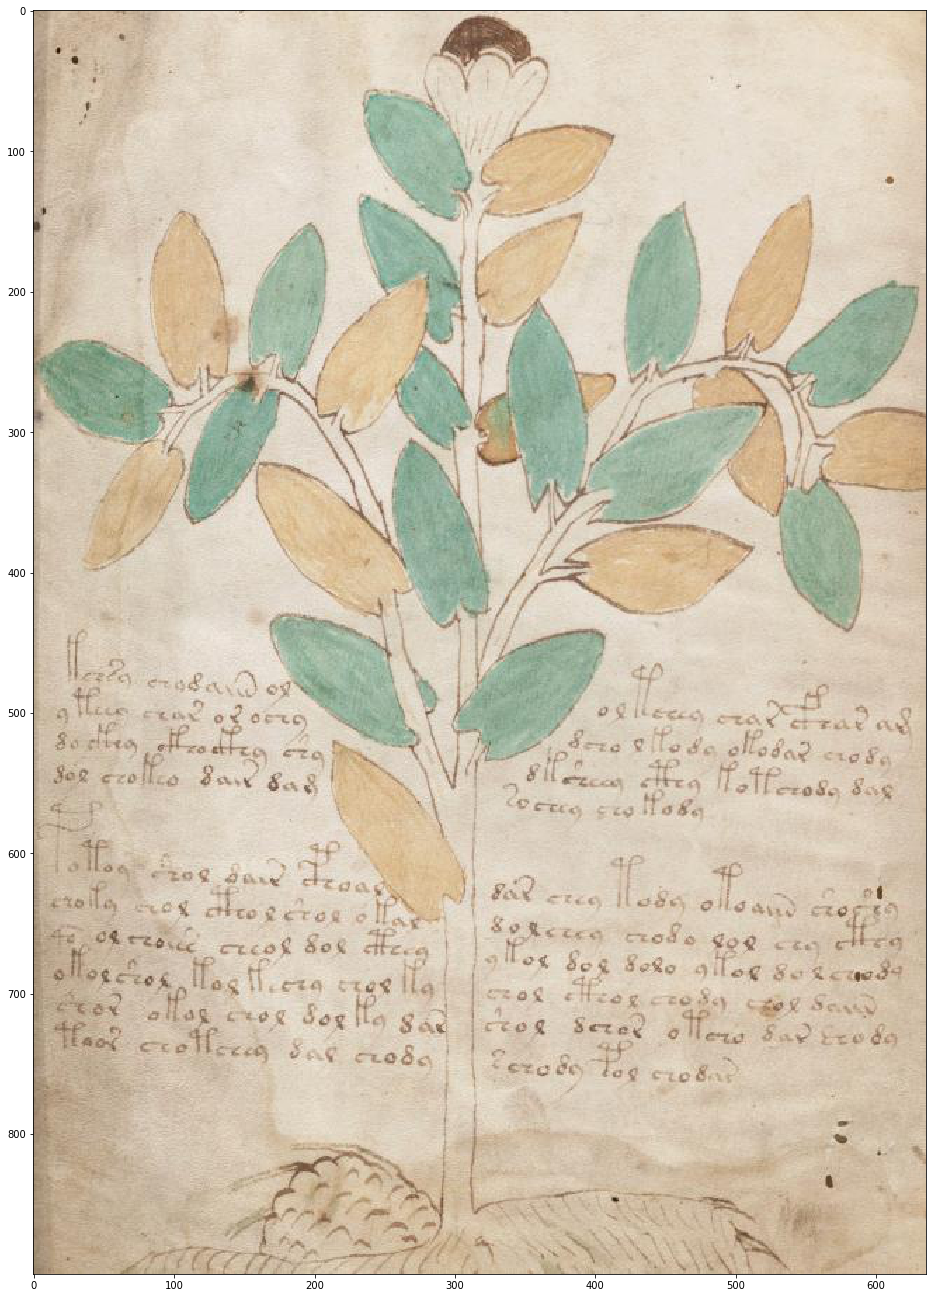

In [7]:
show_page('f1v', figsize=(16,30))

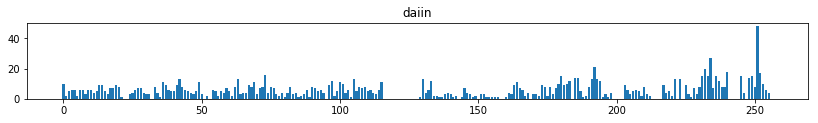

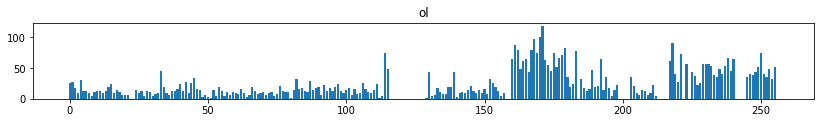

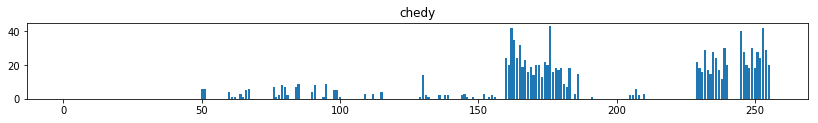

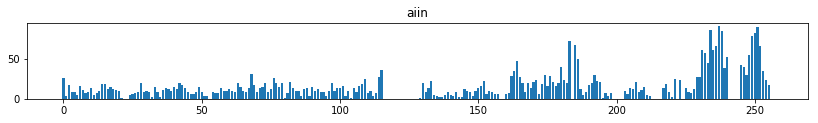

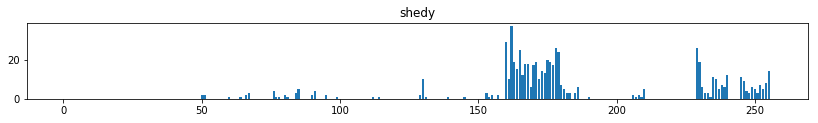

In [8]:
from collections import Counter

words = get_words()
word_counts = Counter(words)
word_map = get_word_map()

for word, _ in word_counts.most_common(5):
  plot_string_freq(word)

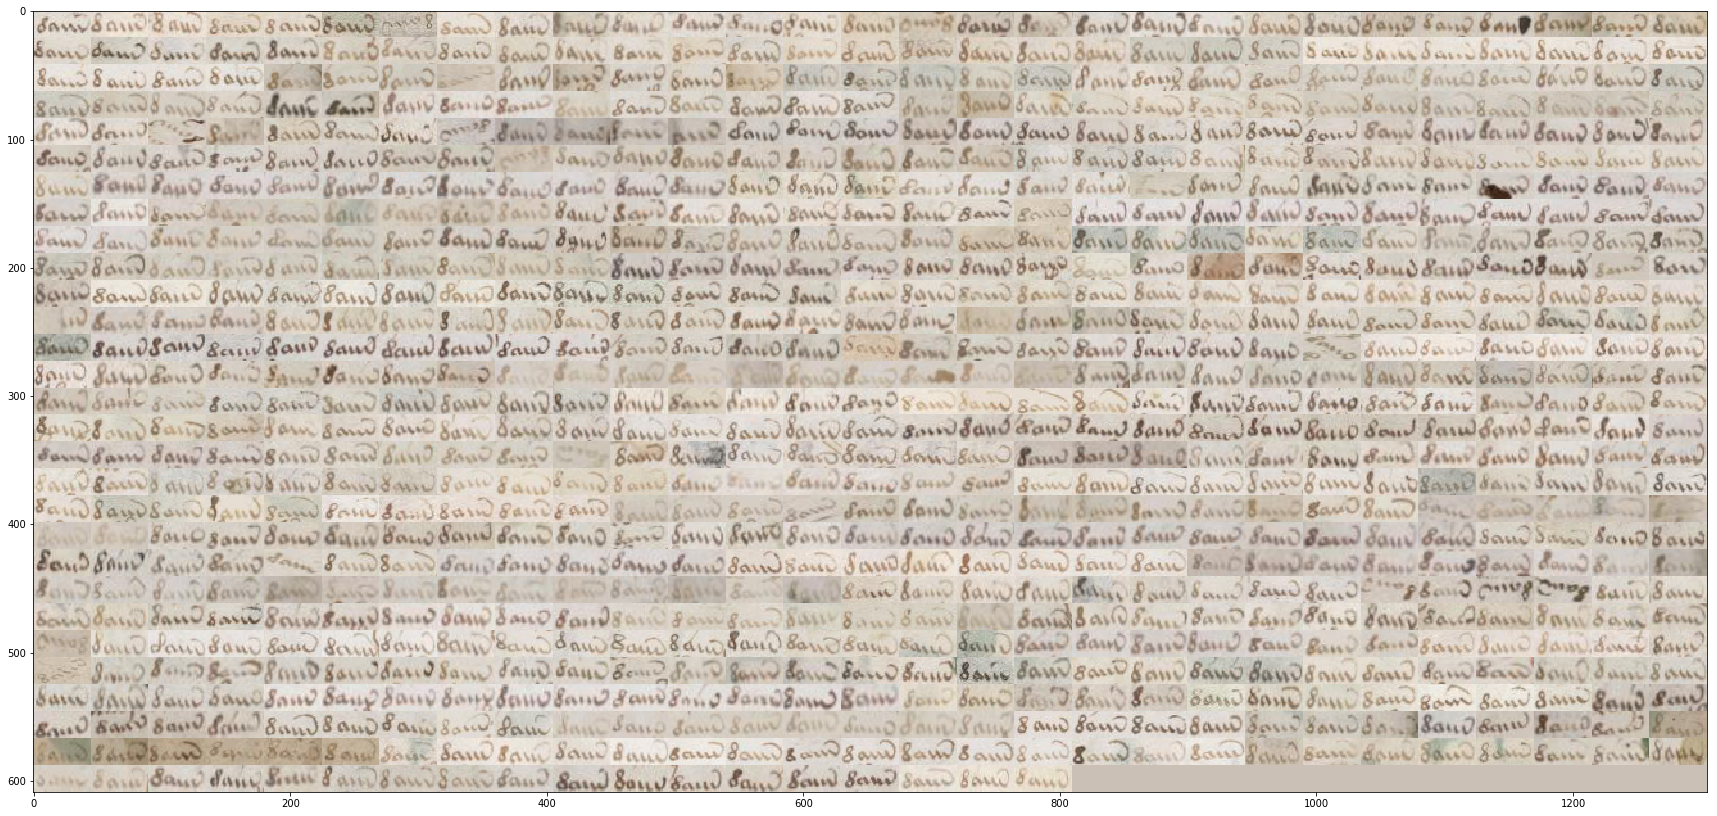

In [9]:
show_word_occurrences('daiin', figsize=(30, 30), grayscale=False)

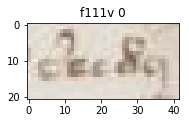

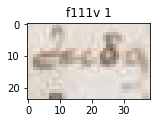

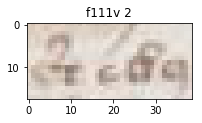

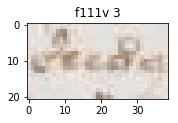

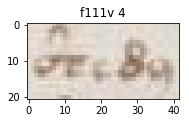

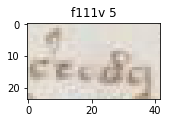

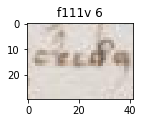

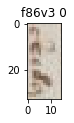

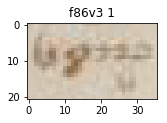

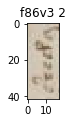

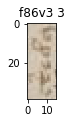

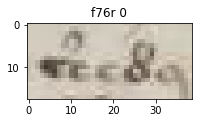

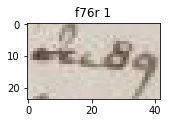

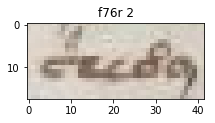

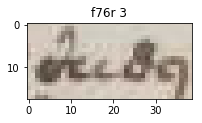

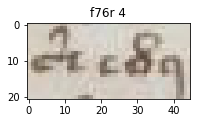

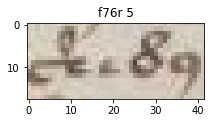

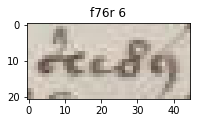

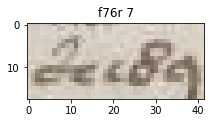

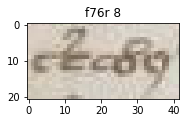

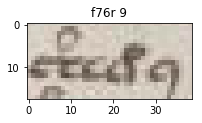

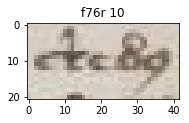

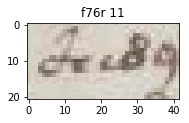

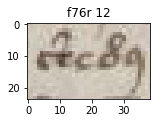

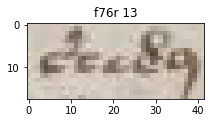

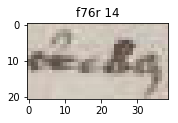

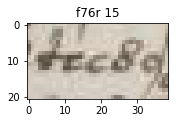

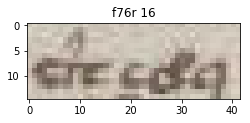

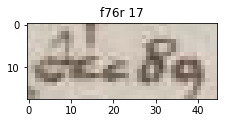

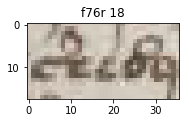

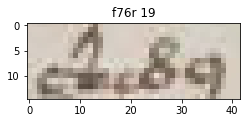

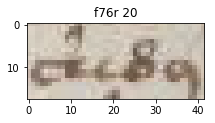

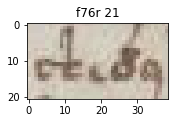

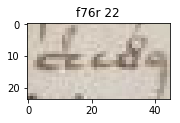

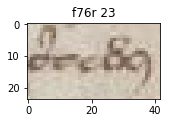

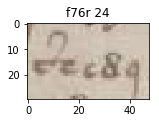

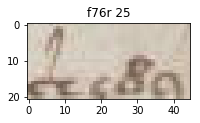

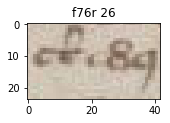

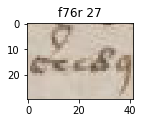

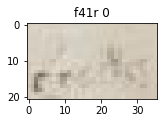

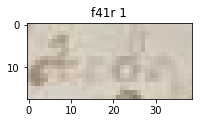

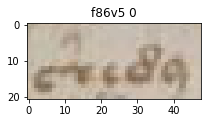

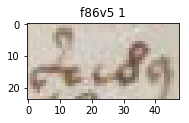

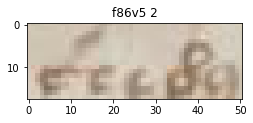

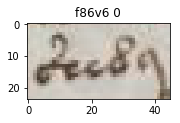

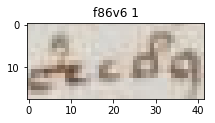

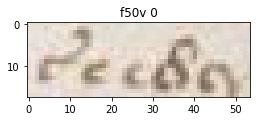

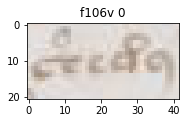

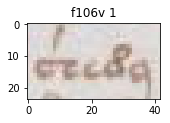

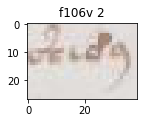

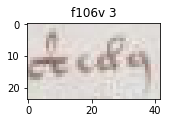

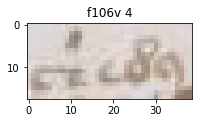

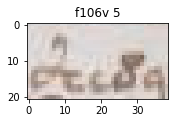

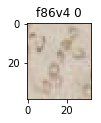

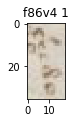

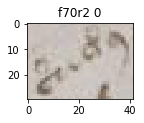

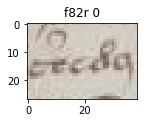

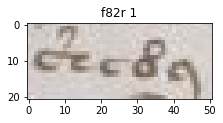

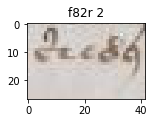

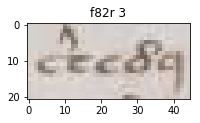

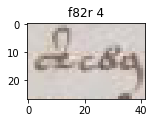

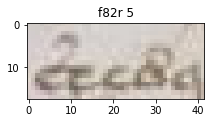

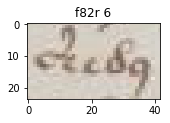

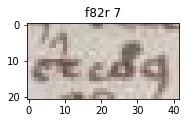

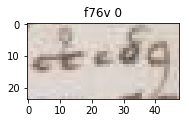

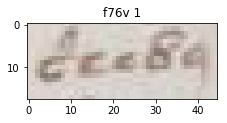

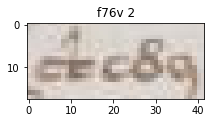

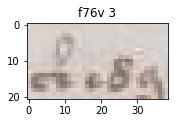

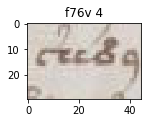

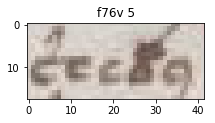

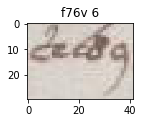

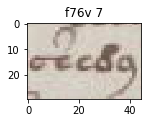

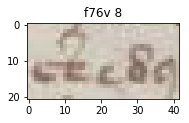

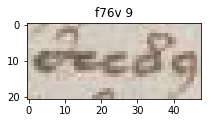

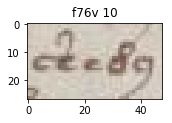

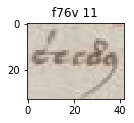

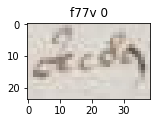

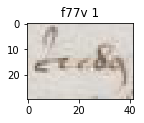

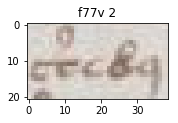

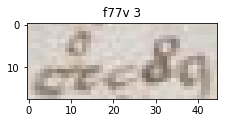

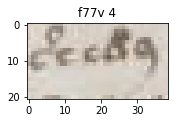

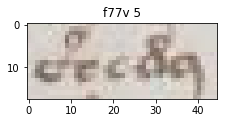

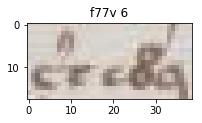

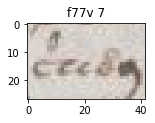

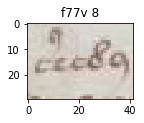

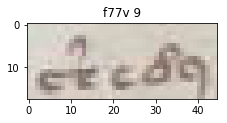

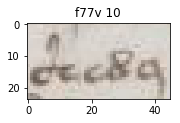

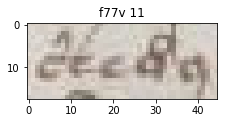

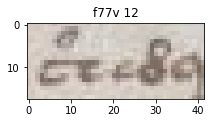

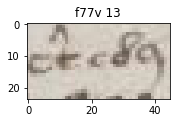

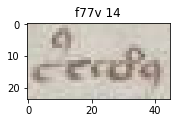

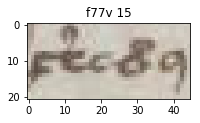

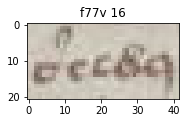

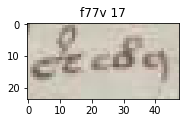

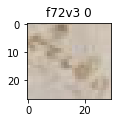

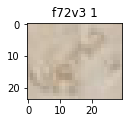

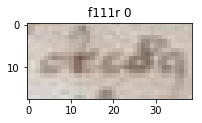

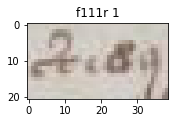

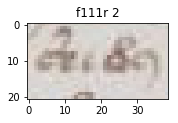

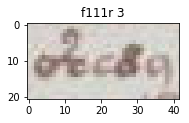

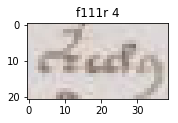

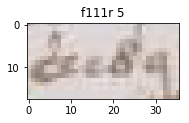

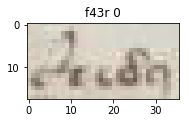

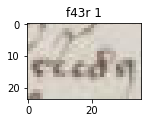

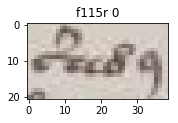

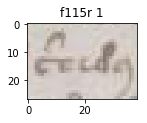

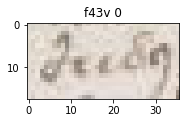

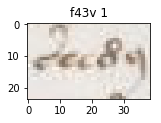

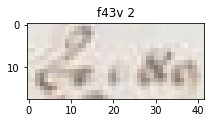

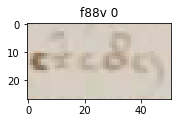

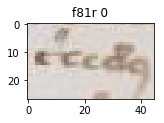

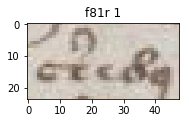

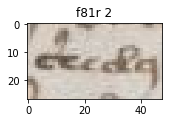

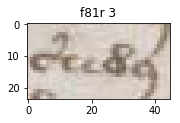

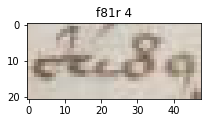

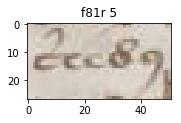

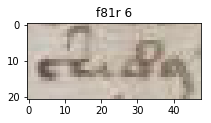

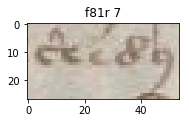

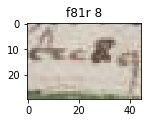

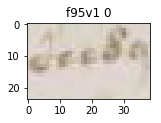

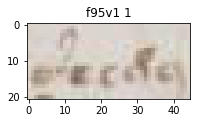

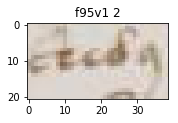

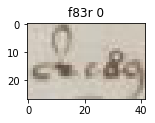

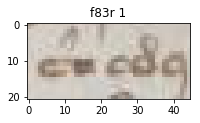

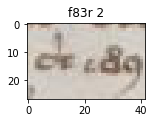

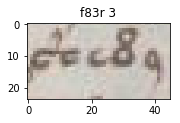

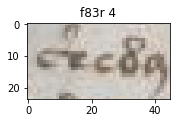

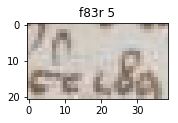

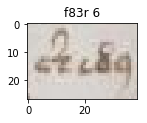

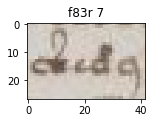

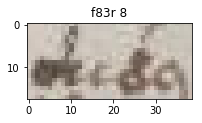

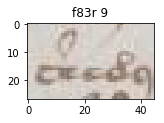

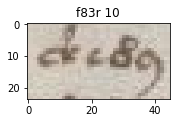

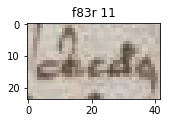

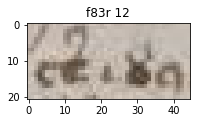

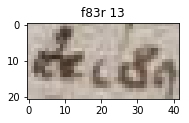

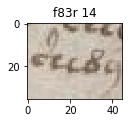

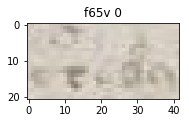

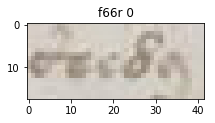

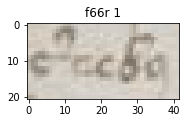

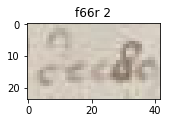

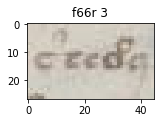

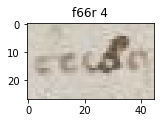

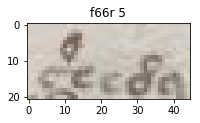

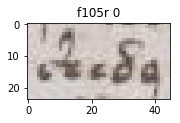

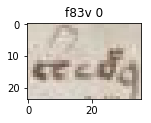

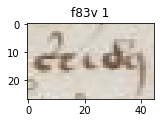

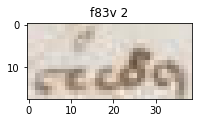

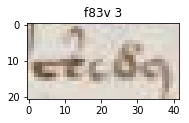

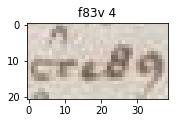

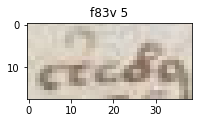

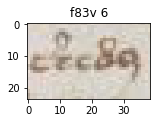

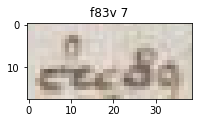

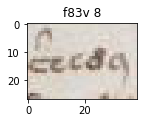

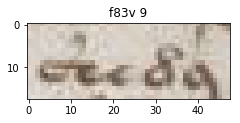

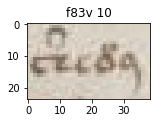

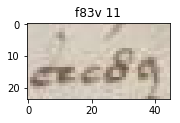

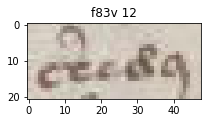

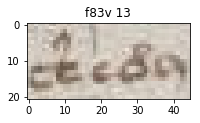

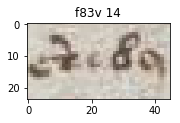

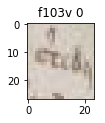

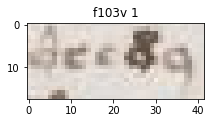

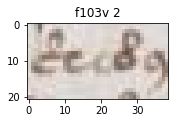

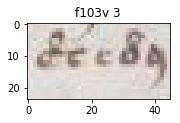

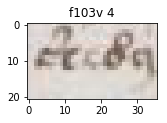

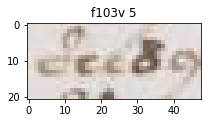

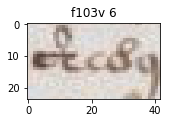

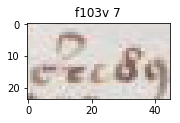

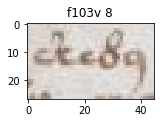

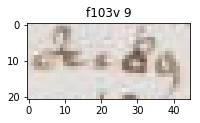

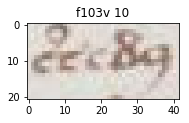

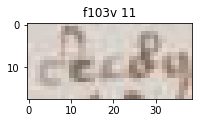

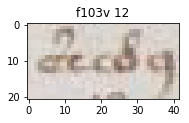

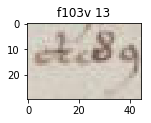

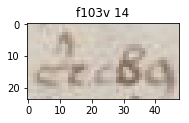

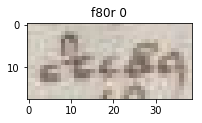

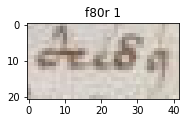

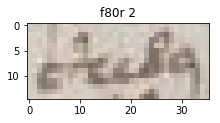

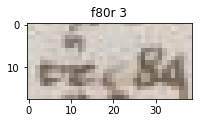

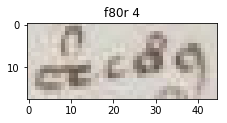

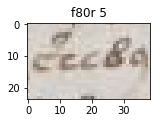

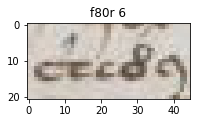

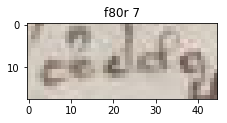

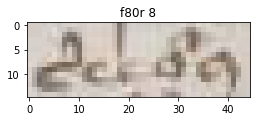

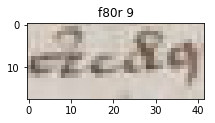

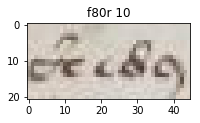

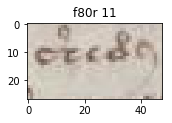

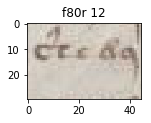

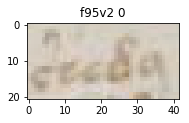

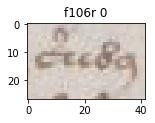

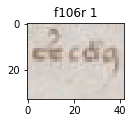

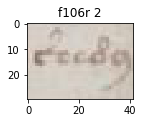

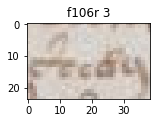

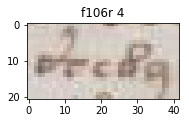

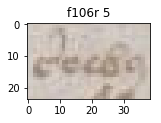

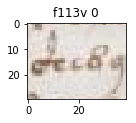

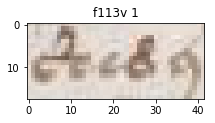

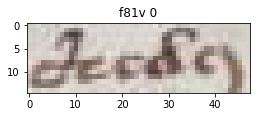

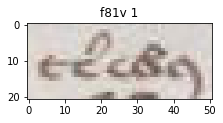

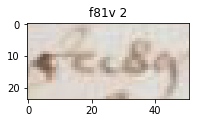

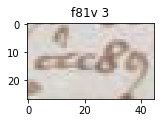

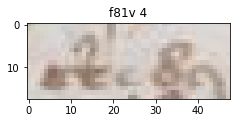

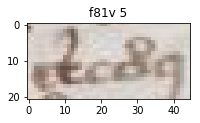

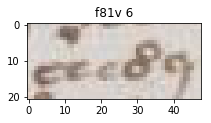

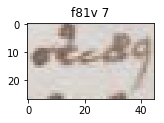

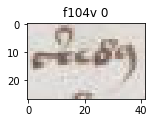

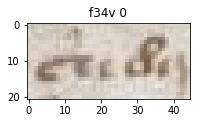

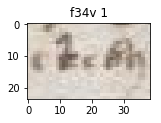

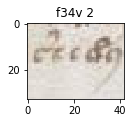

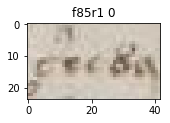

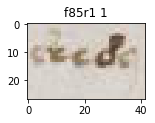

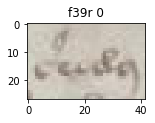

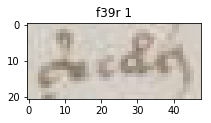

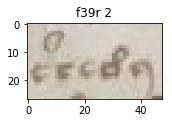

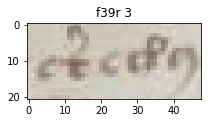

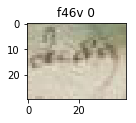

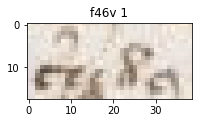

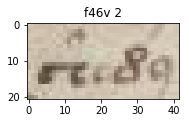

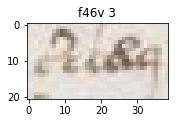

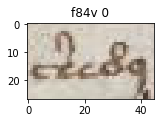

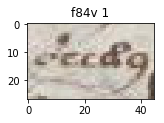

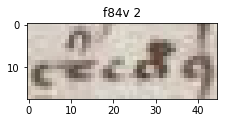

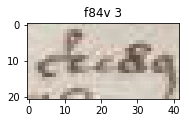

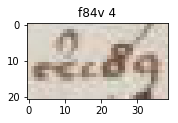

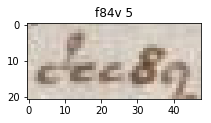

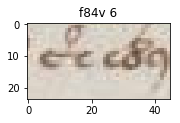

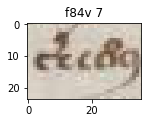

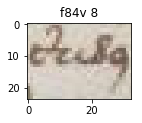

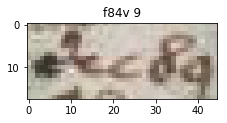

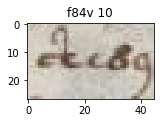

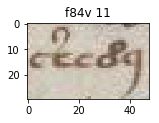

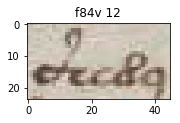

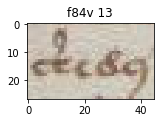

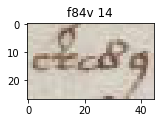

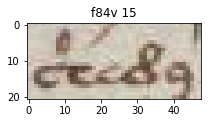

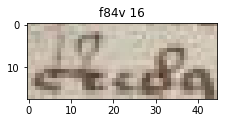

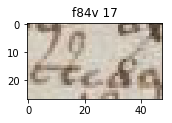

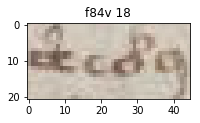

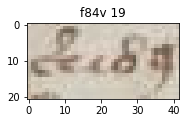

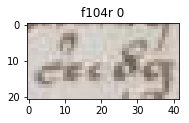

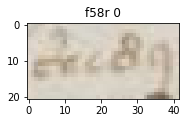

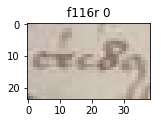

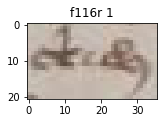

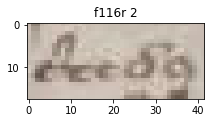

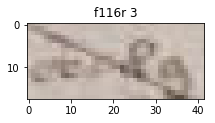

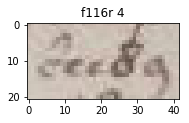

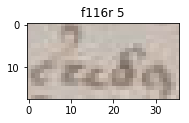

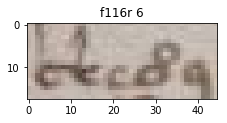

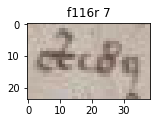

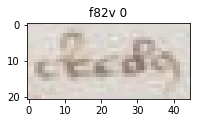

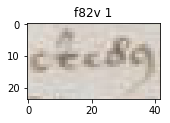

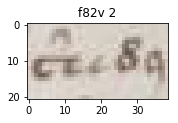

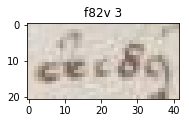

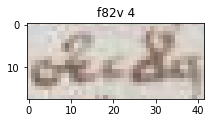

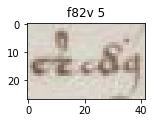

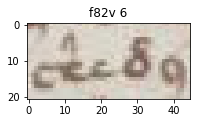

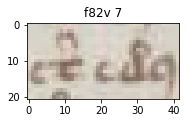

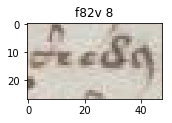

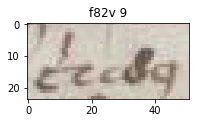

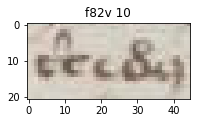

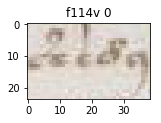

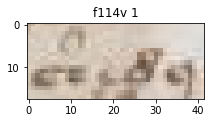

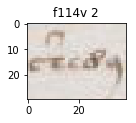

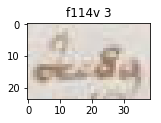

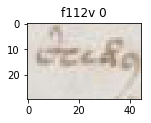

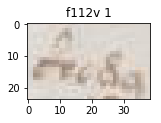

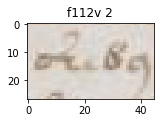

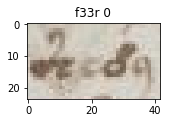

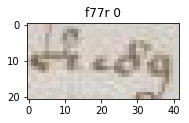

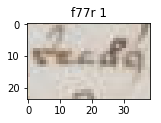

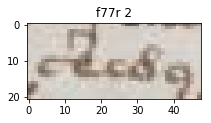

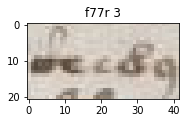

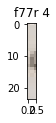

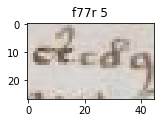

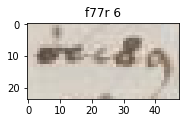

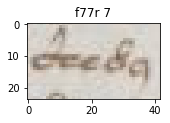

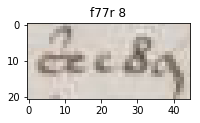

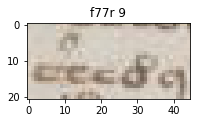

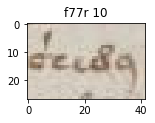

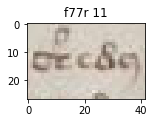

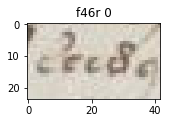

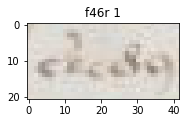

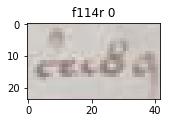

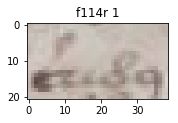

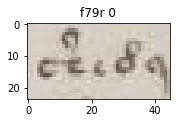

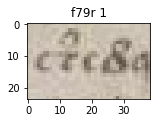

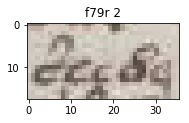

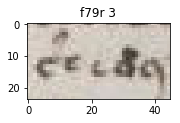

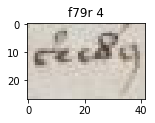

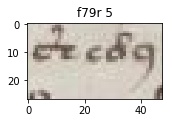

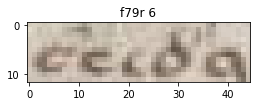

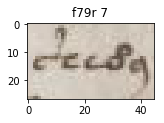

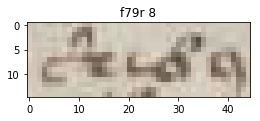

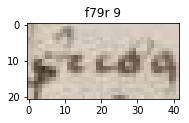

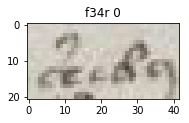

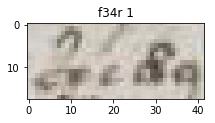

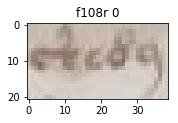

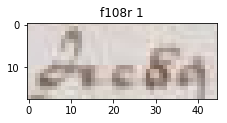

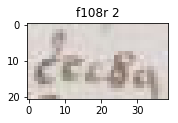

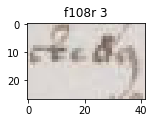

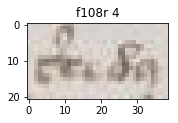

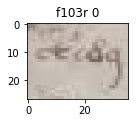

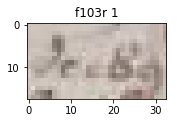

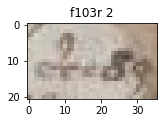

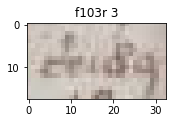

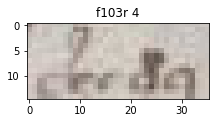

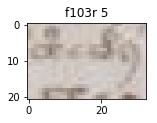

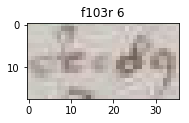

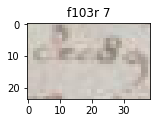

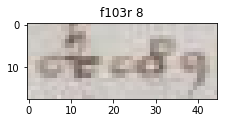

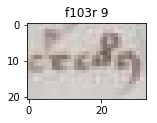

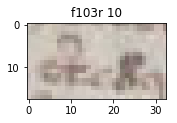

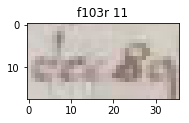

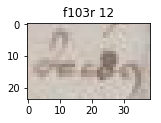

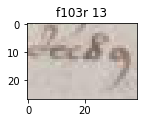

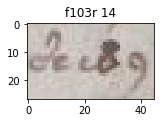

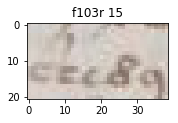

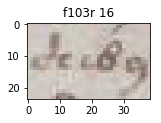

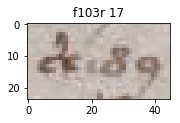

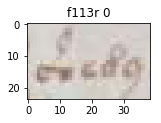

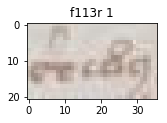

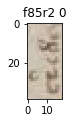

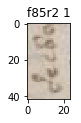

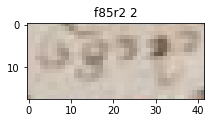

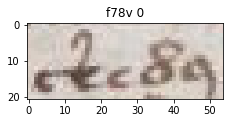

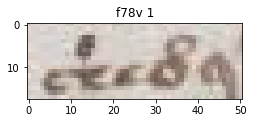

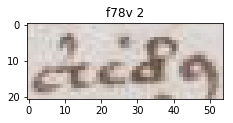

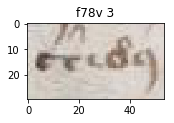

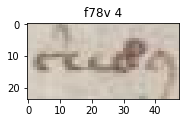

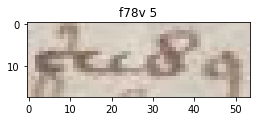

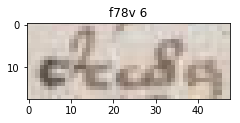

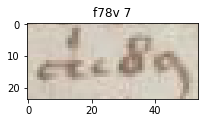

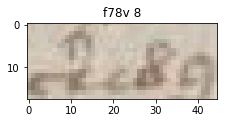

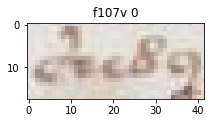

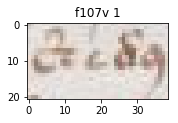

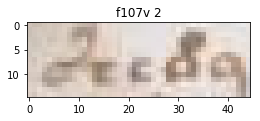

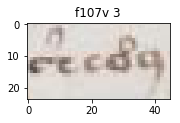

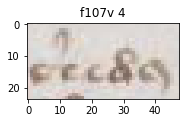

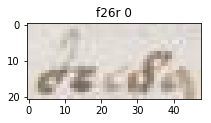

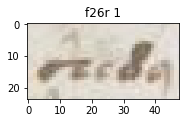

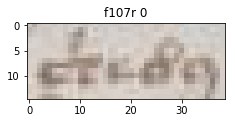

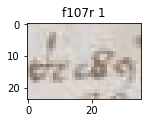

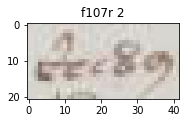

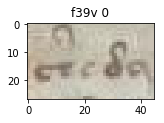

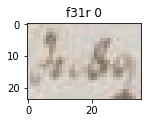

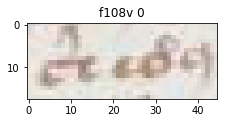

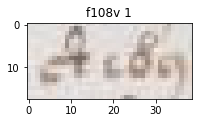

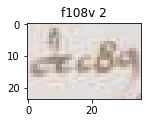

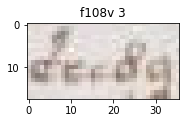

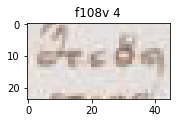

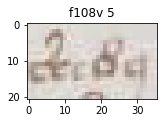

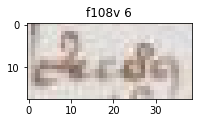

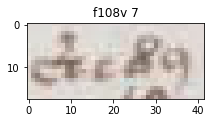

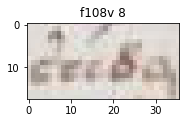

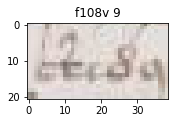

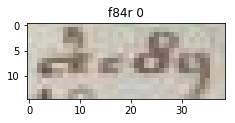

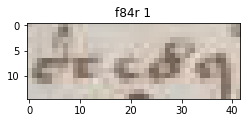

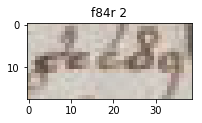

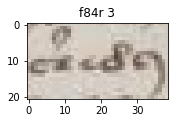

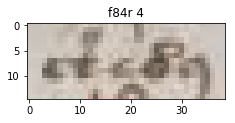

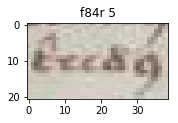

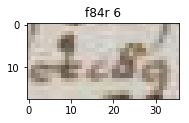

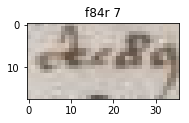

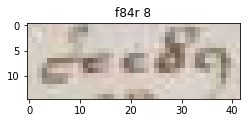

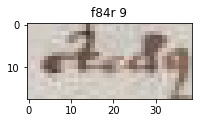

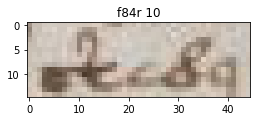

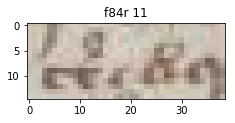

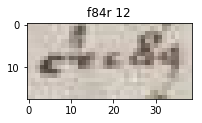

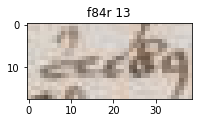

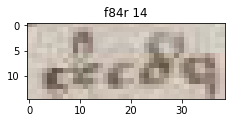

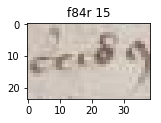

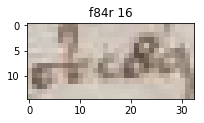

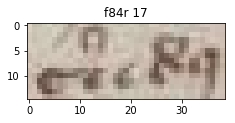

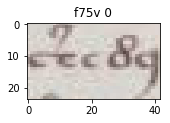

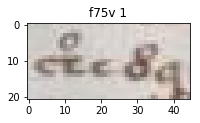

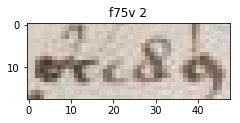

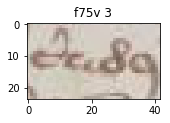

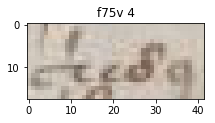

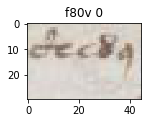

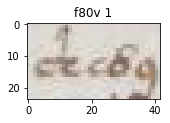

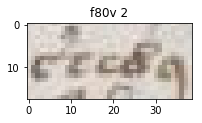

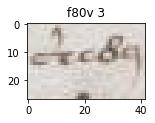

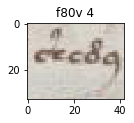

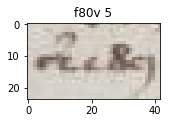

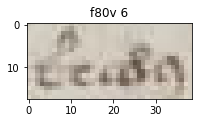

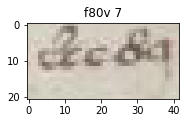

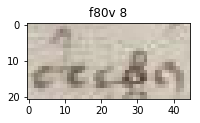

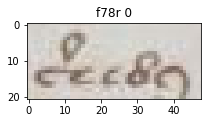

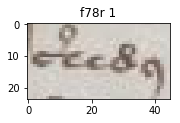

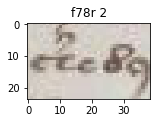

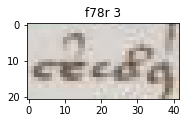

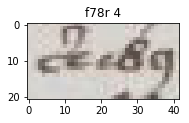

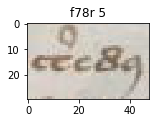

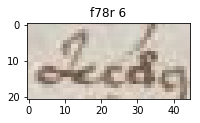

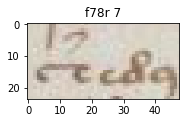

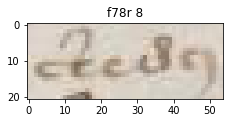

In [10]:
label_word_occurrences('daiin')